# Восстановление золота из руды

**В данной работе нам необходимо подготовить прототип модели машинного обучения для предсказания коэффициента восстановления золота из золотосодержащей руды для компании "Цифра".**

В нашем распоряжении находятся сырые данные с параметрами добычи и очистки золотосодержащей руды. В процессе работы будет необходимо  внимательно изучить данные, очистить их от нежелательных аномалий, пропусков и некорректных значений. Далее проанализируем имеющиеся данные на предмет скрытых аномалий или каких-либо зависимостей. На следующем этапе работы надо будет отобрать необходимые парметры среди данных, на которых мы сможем обучать и тестировать модели машинного обучения. Раздел подбора модели машинного обучения мы разобьем на 2 этапа, по причине необходимости предсказывать коэффициент восстановления золота на 2х технологических этапах. Далее необходимо будет подобрать модели с минимальным отклонением предсказанных коэффициентов и провести этап тестирования на отдельной выборке данных.


## Подготовка данных

### Обзор данных

Рассмотрим все 3 предоставленные датасета

In [ ]:
import pandas as pd
import numpy as np
import pprint

from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

rcParams["figure.figsize"] = 15, 8

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

SEED = 777

In [ ]:
def review(data_way, data_name):
    data_name = pd.read_csv(data_way)
    data_name.info()
    display(ProfileReport(data_name, minimal=True))
    return data_name

In [ ]:
df_train = 0
df_train = review("/datasets/gold_recovery_train_new.csv", df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [ ]:
df_test = 0
df_test = review("/datasets/gold_recovery_test_new.csv", df_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [ ]:
df_full = 0
df_full = review("/datasets/gold_recovery_full_new.csv", df_full)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Также поверхностно рассмотрим корреляцию между признаками на примере одного из датафреймов в котором присутствуют все существующие столбцы.

In [14]:
df_train.corr().style.background_gradient()

По полученным отчетам можно сказать следующее:
- Мы имеем немалое количество данных, в общем около 19,5 тыс строк и 87 столбцов, при этом в тестовой выборке столбцов значительно меньше;
- Столбцы разбиты по стадиям производства, параметрам процессов и по содержанию разных веществ в руде;
- Почти все данные имеют числовой непрерывный формат. Один столбец со строковым значением, в котором указаны дата и время каждого эксперимента;
- Данные имеют некоторое количество пропусков, в худших случаях пропуски достигают 11.3% от значений столбца;
- Распределения данных в столбцах в некоторых случаях далеко от нормального, иногда присутсвуют явные выбросы и экстремальные значения;
- Числовые данные имеют разный масштаб и разброс поэтому впоследствии мы их стандартизируем;
- По таблице корреляции видно, что между некоторыми признаками присутствует явная зависимость. В основном это признаки, показывающие состояние технологического процесса в разных установках. Так как у нас нет данных о том какие из коррелируемых параметров влияют больше на результат обработки, на данный момент, мы не будем удалять параметры, а на этапе выбора моделей обратим внимание на модели менее подверженные отрицательному эффекту мультиколлениарности;
- Также мы имеем 2 целевых признака, которые находятся в столбцах `rougher.output.recovery` , `final.output.recovery` - это расчётные параметры концентрации золота, взятые по данным нам экспериментам,и они практически не коррелируют друг с другом.

### Проверка расчетных целевых параметров

Для большей надежности эксперимента и последующей работы проверим значение одного из целевых признаков. Рассчитаем самостоятельно коэффициент восстановления золота из руды после этапа флотации, а затем найдем среднее абсолютное отклонение расчетного коэффициента от предоставленного.
Коэффициент восстановления находится по следующей формуле:

$$RECOVERY = \frac{C*(F - T)}{F*(C - T)}$$

,где:<br>
C — доля золота в концентрате после флотации - `rougher.output.concentrate_au`;<br>
F — доля золота в сырье до флотации - `rougher.input.feed_au`;<br>
T — доля золота в отвальных хвостах после флотации - `rougher.output.tail_au`.

In [ ]:
df_train["my_recovery"] = (
    df_train["rougher.output.concentrate_au"]
    * (df_train["rougher.input.feed_au"] - df_train["rougher.output.tail_au"])
    * 100
    / df_train["rougher.input.feed_au"]
    / (df_train["rougher.output.concentrate_au"] - df_train["rougher.output.tail_au"])
)

In [ ]:
MAE = mean_absolute_error(df_train["my_recovery"], df_train["rougher.output.recovery"])
f"Среднее абсолютное отклонение = {MAE:.3}"

'Среднее абсолютное отклонение = 1.15e-14'

По результатам проверки можно сказать, что значение коэффициента востановления в предоставленных данных корректно и не нуждается в дополнительных расчет. Можем его использовать со спокойной совестью.

### Разница в столбцах в данных

Как мы заметили ранее, у нас имеется разница в количестве параметров в тренировочном и тестовом датасете. Рассмотрим эти слолбцы более детально.

In [10]:
lost_columns = [x for x in df_train.columns if x not in df_test.columns]
lost_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В первую очередь важно заметить, что этих столбцов нет в выборке, по которой будут тестировать модель, а значит мы не можем использовать данные столбцы для последующего обучения модели. <br>
Среди этих столбцом мы видим исключительно параметры сырья на выходе из различных технологических этапов обработки и очистки, а также несколько параметров, полученных путем расчета отношения веществ входящих или добавленных в процессе обработки. Также здесь присутствуют 2 целевых расчетных параметра, на которые мы будем ориентироваться при обучении и тестировании модели.<br>
При этом можно заметить, что некоторые выходные параметры содержания в руде сторонних металлов скорее всего совсем не несут практической пользы для  наших будущих вычислений.

### Предобработка данных

По результатам обзора наших данных были выявлены проблемы с пропусками, а также странности в распределении данных и различные выбросы в них. При этом знаний о технологических процессах и возможных диапазонах данных у нас явно не хватает, поэтому удалять лишние параметры мы не будем. Оставим выбросы и сомнительные распределения пока на месте и займемся пропусками.<br>
Для начала посмотрим внимательнее нет ли пропусков среди целевых показателей.

In [ ]:
target_columns = ["final.output.recovery", "rougher.output.recovery"]

[x[target_columns].isna().sum() for x in [df_train, df_full]]

[final.output.recovery      0
 rougher.output.recovery    0
 dtype: int64,
 final.output.recovery      0
 rougher.output.recovery    0
 dtype: int64]

С целевыми данными все в порядке.<br>
Среди столбцов наших данных с пропусками присутствуют столбцы со свойствами руды, поступающей на обработку и столбцы со свойствами процессов обработки. Рассуждая логически можно предположить, что исходные данные свойств руды дают нам основное знание о наличии золота. Таким образом заполнять пропуски во входных данных не представляется разумным, поэтому удалим такие строки. Пропуски в данных со свойствами процессов флотации и очистки заполним ближайшим по индексу значением, так как можно заметить, что эксперименты идущие друг за другом имеют очень схожие параметры.

In [ ]:
# напишем функцию, которая удалит строки с пропусками на входных данных (rougher\.input\.feed...)
# и заполнит пропуски методом ffil на остальных данных. Применим функцию ко всем датасетам.


def fill_remove(data):
    feed_columns = data.columns.str.extract(r"rougher\.input\.feed(.*)").dropna().index

    data = data.loc[data.iloc[:, feed_columns].dropna().index]

    data[df_test.columns] = data[df_test.columns].ffill()

    return data

In [17]:
df_train, df_test, df_full = [fill_remove(x) for x in [df_train, df_test, df_full]]

## Анализ данных

### Проверка распределения металлов в руде в процессе обработки

Посмотрим как меняются концентрации металлов в руде после каждого из технологических процессов.

In [ ]:
# создадим для удобства отдельные таблицы для каждого металла

df_au = df_train[
    [
        "rougher.input.feed_au",
        "rougher.output.concentrate_au",
        "primary_cleaner.output.concentrate_au",
        "final.output.concentrate_au",
    ]
]

df_ag = df_train[
    [
        "rougher.input.feed_ag",
        "rougher.output.concentrate_ag",
        "primary_cleaner.output.concentrate_ag",
        "final.output.concentrate_ag",
    ]
]

df_pb = df_train[
    [
        "rougher.input.feed_pb",
        "rougher.output.concentrate_pb",
        "primary_cleaner.output.concentrate_pb",
        "final.output.concentrate_pb",
    ]
]

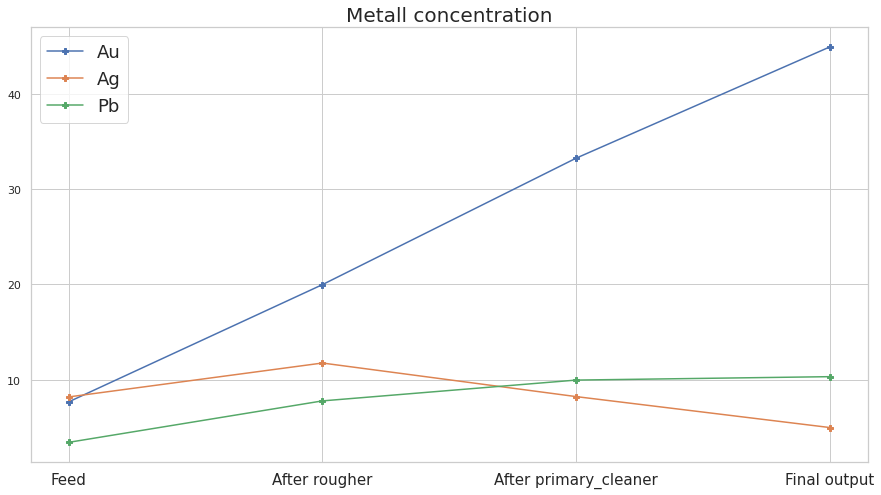

In [ ]:
# Посмотрим как меняются медианные значения концентрации разных металлов на разных стадиях.

for data in [df_au, df_ag, df_pb]:
    variation = []

    for i in range(len(data.columns)):
        variation.append(data.iloc[:, i].median())

    plt.plot(variation, "-P")
    plt.legend(["Au", "Ag", "Pb"], fontsize=18)
    plt.xticks(
        ticks=np.arange(4),
        labels=["Feed", "After rougher", "After primary_cleaner", "Final output"],
        fontsize=15,
    )
    plt.grid(True)
    plt.title("Metall concentration", fontsize=20)

Теперь рассмотрим изменение концентраций металлов более детально, построим распределеиня концентраций для каждого случая

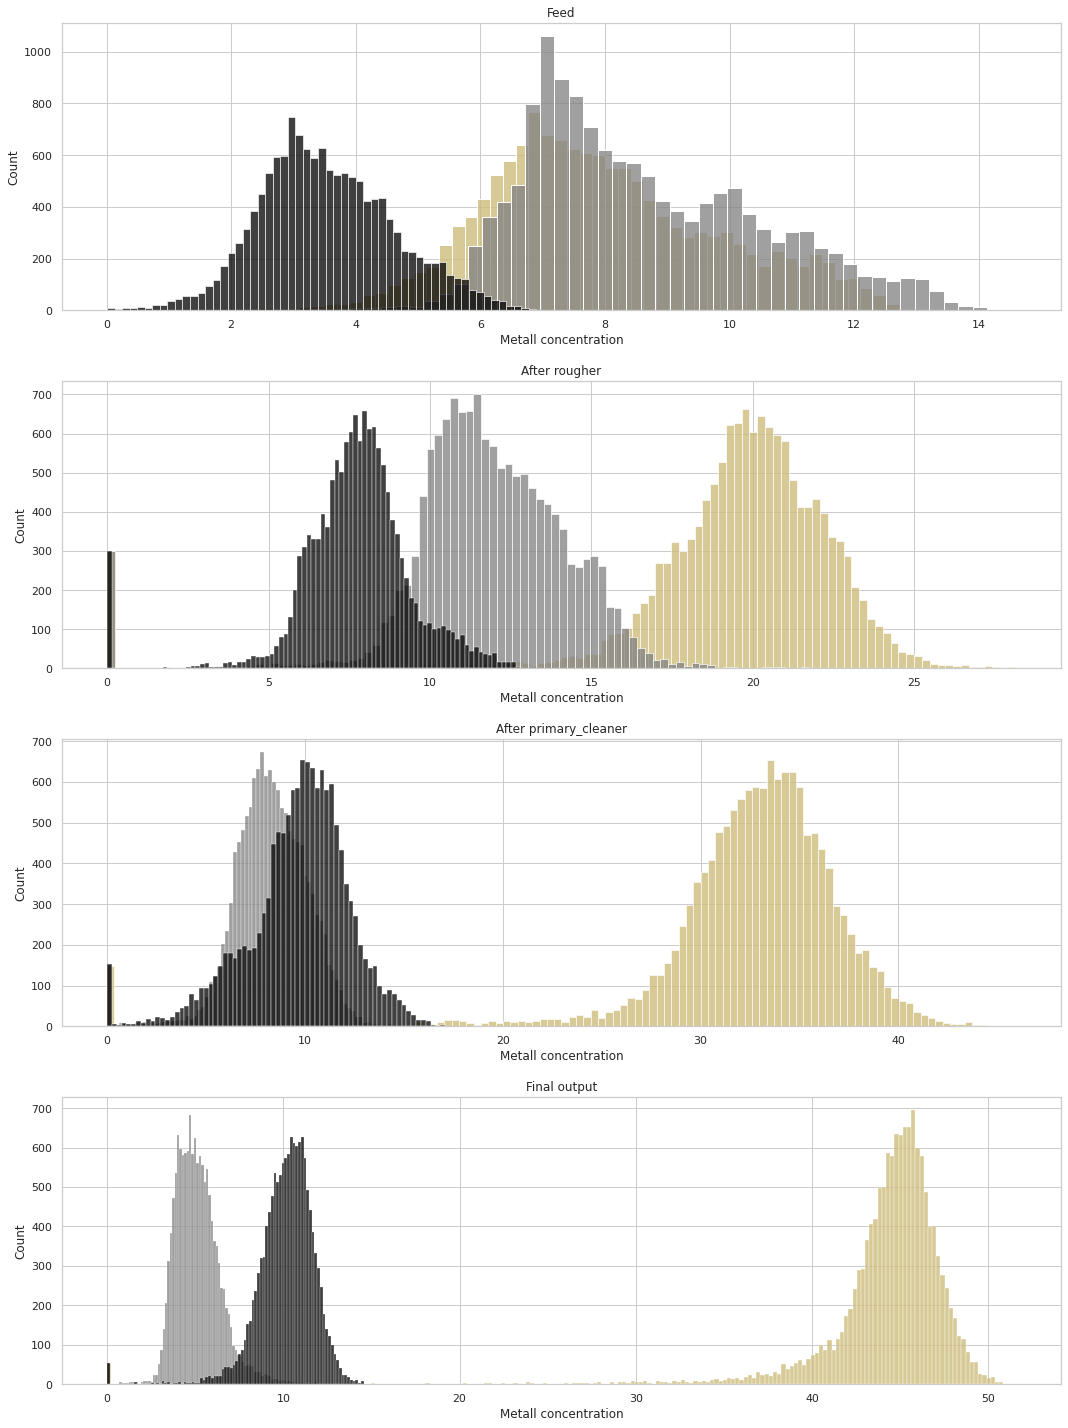

In [ ]:
fig1, axs = plt.subplots(4, 1, figsize=(15, 20))
names = ["Feed", "After rougher", "After primary_cleaner", "Final output"]

for stage in range(len(df_au.columns)):
    sns.histplot(df_au.iloc[:, stage], ax=axs[stage], color="y")
    sns.histplot(df_ag.iloc[:, stage], ax=axs[stage], color="grey")
    sns.histplot(df_pb.iloc[:, stage], ax=axs[stage], color="black")
    axs[stage].set(xlabel="Metall concentration", title=names[stage])
    axs[stage].grid(True)


fig1.tight_layout(h_pad=1.5)

График показывает, что мы имеем в целом логичный процесс - с каждой следующей операцией концентрация золота увеличивается, тогда как остальные концентрации металлов либо уменьшаются, как серебро, либо слегка увеличиваются - как свинец. При этом заметно появление аномальных значений с концентрациями различных металлов в районе 0. Более подробно рассмотрим эту аномалию в пункте [2.3](#1)

### Проверка распределения размера гранул

Среди параметров руды, поступающей на обогащение, есть параметр размера гранул. Посмотрим как распределется этот параметр на наших выборках и на разных стадиях процесса.

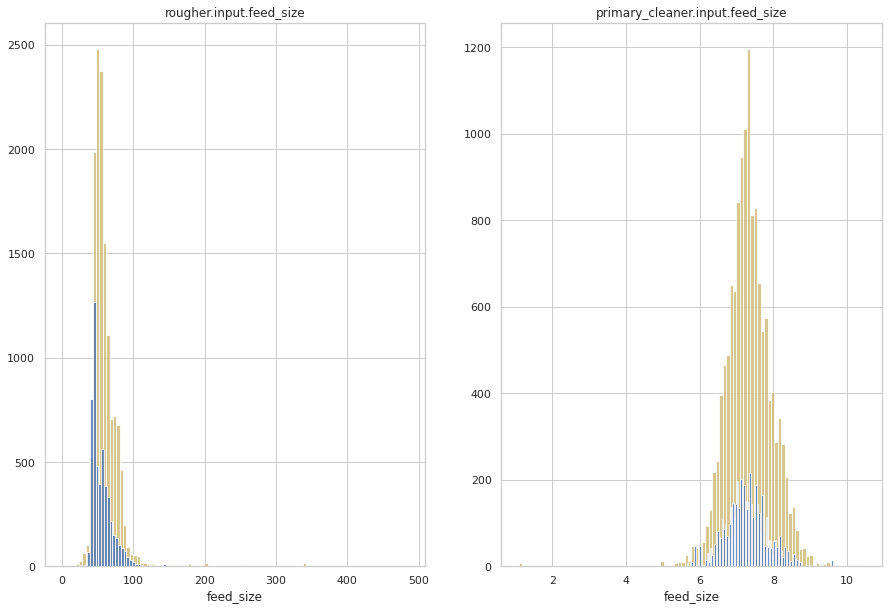

In [ ]:
i = 0
fig2, axq = plt.subplots(1, 2, figsize=(15, 10))

for column in ["rougher.input.feed_size", "primary_cleaner.input.feed_size"]:
    df_train[column].hist(bins=100, alpha=0.8, ax=axq[i], color="y")
    df_test[column].hist(bins=100, alpha=0.8, ax=axq[i], color="b")
    axq[i].set(xlabel="feed_size", title=column)
    i += 1

Здесь мы видим в общем очень похожее распределение данных. При этом на стадии rougter.input.feed_size тестовые данные по диапазону совпадают с данными в обучающей выборке. А вот на стадии primary_cleaner.input.feed_size мы видим, что на тестовой выборке диапазон значений выходит за пределы диапазона тренировочной выборки. Посмотрим сколько экспериментов находятся в таком диапазоне (>10)

In [ ]:
# Количество строк с размером гранул больше 10ти на тесте
df_test.loc[
    df_test["primary_cleaner.input.feed_size"]
    > df_train["primary_cleaner.input.feed_size"].max()
].shape

(2, 53)

Всего 2 эксперимента, выходящие за возможности нашей обучающей выборки. Для корректных предсказаний модели просто избавимся от этих строк.

In [ ]:
df_test = df_test.drop(
    index=df_test.loc[
        df_test["primary_cleaner.input.feed_size"]
        > df_train["primary_cleaner.input.feed_size"].max()
    ].index
)

### Суммарная концентрация металлов  
<a id='1'></a>

Теперь взглянем на тот как распределяются суммарные концентрации всех трех металлов в наших экспериментах на разных стадиях производства.

In [ ]:
names = ["before", "after_float", "after_clean1", "after_clean2"]

for i in range(4):
    df_train[names[i]] = df_au.iloc[:, i] + df_ag.iloc[:, i] + df_pb.iloc[:, i]

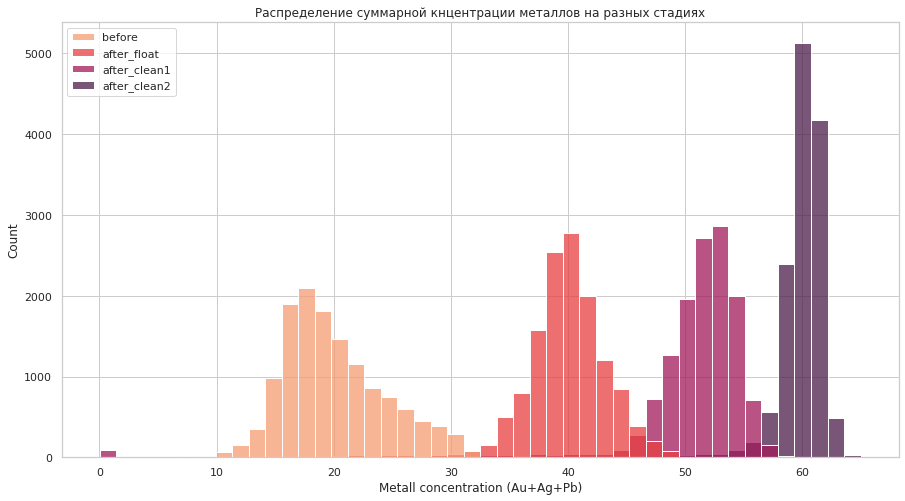

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.histplot(df_train[names], palette="rocket_r")

ax.set(
    xlabel="Metall concentration (Au+Ag+Pb)",
    title="Распределение суммарной кнцентрации металлов на разных стадиях",
);

По графику можно увидеть следующее - распределения суммарных концентраций выглядит в основном нормально, каждая следующая суммарная концентрация смещается по диапазону в большую сторону. Это нам также подтверждает график из пункта 3.1. Однако есть подозрительное место на графике - значения около 0 - если мы обогащаем руду, то как могут возникать нулевые значения после стадий флотации или очистки. Для более наглядной картины построим дополнительный график, который показывает как изменяется концентрация металлов на каждой стадии на каждом эксперименте.

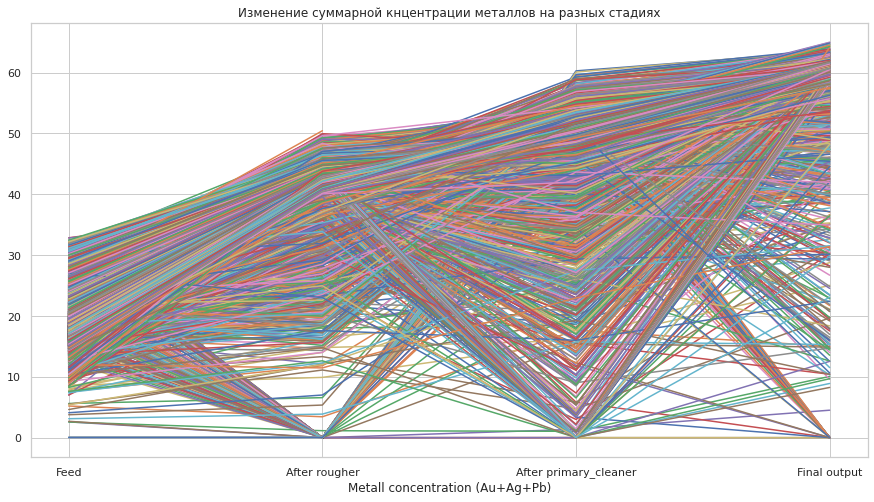

In [ ]:
for i in df_train.index:
    plt.plot(df_train.loc[i][names], "-")

plt.xticks(
    ticks=np.arange(4),
    labels=["Feed", "After rougher", "After primary_cleaner", "Final output"],
)
plt.title("Изменение суммарной кнцентрации металлов на разных стадиях")
plt.xlabel("Metall concentration (Au+Ag+Pb)");

График получился тяжёлый, не очень презентабельный, но очень наглядный для нашей ситуации. Здесь чётко видно, что в ряде экспериментов после каждого из технологических процессов суммарная концентрация металлов падает до 0 и потом возвращается со значениями больше, чем они были до падения. Здесь явно произошли ошибки с расчётами или сбой системы отслеживания концентраций на какое-то время. Посмотрим сколько экспериментов имеют такие ошибки.

In [ ]:
df_train.loc[
    (df_train["after_float"] == 0)
    | (df_train["after_clean1"] == 0)
    | (df_train["after_clean2"] == 0)
].shape

(402, 91)

Получается, что около 3х % нашей тренировочной выборки имеют эксперименты с нарушениями. Удалим эти строки, чтобы не нагружать нашу модель сомнительными данными.

In [ ]:
df_train = df_train.drop(
    index=df_train.loc[
        (df_train["after_float"] == 0)
        | (df_train["after_clean1"] == 0)
        | (df_train["after_clean2"] == 0)
    ].index
)

## Модель

### Оценочная функция работы модели

Введем функции оценки работы модели на основе оценки sMAPE. Также сделаем функцию расчета суммарной оценки по предсказаниям на начальном этапе и на конечном этапе обработки золотосодержащей руды.

In [ ]:
def sMAPE(y, y_hat):
    sMAPE_score = (sum(abs(y - y_hat) / ((abs(y) + abs(y_hat)) / 2)) / len(y)) * 100
    return sMAPE_score


def full_score(sMAPE_rou, sMAPE_final):
    return sMAPE_rou * 0.25 + sMAPE_final * 0.75

### Разбиение данных

Так как целевые параметры для проверки работы модели на тестовой выборке находятся в другом датасете (`df_full`) а все эксперименты в датасетах пересекаются по значению столбца `date`, установим этот столбец в качестве индекса для всех таблиц.

In [ ]:
def new_index(data):
    data.set_index(data["date"], drop=True, inplace=True)
    data = data.drop(columns="date")
    return data


df_train, df_test, df_full = [new_index(x) for x in [df_train, df_test, df_full]]

Теперь вытащим целевые столбцы в отдельные переменные

In [ ]:
test_target_rou = df_full.loc[df_test.index]["rougher.output.recovery"]
test_target_final = df_full.loc[df_test.index]["final.output.recovery"]

train_target_rou = df_train["rougher.output.recovery"]
train_target_final = df_train["final.output.recovery"]

Следующим этапом необходимо разделить данные для обучения 2х моделей на разных этапах обработки.<br> 
Для предсказания коэффициента обогащения после этапа флотации (rougher) мы возьмём параметры которые относятся к начальному состоянию руды и параметры относящиеся непосредственно к процессу флотации <br>
Для предсказаний модели на финальном этапе (после очисток) мы возьмём все входные данные этапов очистки и данные состояния на этапах первой и второй очистки. Для работы второй модели мы не будем использовать параметры с процесса флотации.

In [ ]:
def simple_split(data):
    df_rou = data[df_test.filter(like="rougher", axis=1).columns]
    df_final = data[df_test.columns.symmetric_difference(df_rou.columns)]
    return df_rou, df_final

In [ ]:
train_features_rou, train_feature_final = simple_split(df_train)
test_features_rou, test_feature_final = simple_split(df_test)

[
    x.shape
    for x in [
        train_features_rou,
        train_feature_final,
        test_features_rou,
        test_feature_final,
    ]
]

[(13426, 22), (13426, 30), (5264, 22), (5264, 30)]

Сделаем несколько подготовительных данных перед обучением моделей:
- создадим словарь для ступней предсказания;
-запишем нашу функцию оценки в переменную через 'make_scorer';
-также создадим scaler для последующей стандартизации параметров.

In [ ]:
stages = {
    "rou_stage": [train_features_rou, train_target_rou],
    "final_stage": [train_feature_final, train_target_final],
}

In [30]:
score_smape = make_scorer(sMAPE, greater_is_better=False)

In [31]:
scaler = StandardScaler()

Теперь создадим базовую, простую модель на основе Модели дерева решений. Сразу обучим её на тестовых данных и найдём отклонения предсказания на 2х этапах и общую оценку. Далее будем сравнивать оценки наших моделей с базовой оценкой и смотреть на сколько улучшаются результаты.

In [ ]:
%%time
base_model = DecisionTreeRegressor(random_state=SEED)
scores = {"base_scores": []}

for key in stages:
    base_pipe = Pipeline([("sc", scaler), ("mod_reg", base_model)], verbose=False)

    base_params = {"mod_reg__max_depth": range(2, 15)}

    base_grid = GridSearchCV(
        base_pipe, param_grid=base_params, cv=5, scoring=score_smape
    )

    base_grid.fit(stages[key][0], stages[key][1])

    scores["base_scores"] += [base_grid.best_score_ * -1]

print("Оценки на разных этапах обработки -", scores)
(
    "Общая оценка базовой модели =",
    full_score(scores["base_scores"][0], scores["base_scores"][1]),
)

Оценки на разных этапах обработки - {'base_scores': [6.685871295630525, 10.447165306017478]}
CPU times: total: 20.9 s
Wall time: 21 s


('Общая оценка базовой модели =', 9.50684180342074)

Следующим этапом будем перебор моделей и их параметров в поисках той, которая покажет наилучшие результат на тренировочных данных. Для удобства создадим словари с моделями, с их параметрами, а также в процессе создания запишем лучшие оценки моделей в словарь `scores`. Для наших целей, возьмем следующие 3 модели:
1. Модель RandomForestRegressor - Случайный лес;
2. Модель Ridge - гребневая ридж регрессия;
3. Модель KNeighborsRegressor - модель ближайших соседей.

При каждом обучении модели будем делать стандартизацию для параметров в обучающей части данных.

In [ ]:
models = {
    "Forest": RandomForestRegressor(random_state=SEED),
    "Ridge": Ridge(random_state=SEED),
    "Neighbors": KNeighborsRegressor(),
}

model_params = {
    "Forest": {
        "Forest__n_estimators": [50, 120, 230],
        "Forest__max_depth": range(2, 7),
    },
    "Ridge": {
        "Ridge__alpha": [0, 1, 1.2, 5, 20],
        "Ridge__solver": ["svd", "cholesky", "sparse_cg", "lsqr"],
    },
    "Neighbors": {
        "Neighbors__n_neighbors": [5, 20],
        "Neighbors__algorithm": ["ball_tree", "kd_tree", "brute"],
        "Neighbors__p": [1, 2],
    },
}

Сначала подберём модель для этапа флотации

In [ ]:
%%time
i = 555

for key in models:
    pipe = Pipeline([("sc", scaler), (key, models[key])], verbose=False)
    grid = GridSearchCV(pipe, param_grid=model_params[key], cv=5, scoring=score_smape)
    grid.fit(stages["rou_stage"][0], stages["rou_stage"][1])

    if (grid.best_score_ * -1) < i:
        best_model_rou = grid.best_estimator_
        i = grid.best_score_ * -1

    scores[key] = [grid.best_score_ * -1]


print(best_model_rou)
print("Оценки моделей:")
pprint.pprint(scores)

Pipeline(steps=[('sc', StandardScaler()),
                ('Forest',
                 RandomForestRegressor(max_depth=5, n_estimators=230,
                                       random_state=777))])
Оценки моделей:
{'Forest': [6.383855679013314],
 'Neighbors': [7.404087314182841],
 'Ridge': [6.586273548440488],
 'base_scores': [6.685871295630525, 10.447165306017478]}
CPU times: total: 8min 2s
Wall time: 8min


Лучше всего себя показывает модель `RandomForest` её оценка немного лучше базовой модели, но всё же лучше. Тогда как модель `KNeighbors` показывает результаты хуже базового решающего дерева.

Перед запуском поиска оптимальной второй модели(для следующих этапов очистки) введём в данные новый параметр, который будет состоять из значений коэффициента обогащения, предсказанного первой моделью на этапе флотации.

In [ ]:
train_feature_final["rougher.output.predict.recovery"] = best_model_rou.predict(
    stages["rou_stage"][0]
)

C:\Users\user\AppData\Local\Temp\ipykernel_166484\2462146007.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_feature_final['rougher.output.predict.recovery'] = best_model_rou.predict(stages['rou_stage'][0])


Теперь подберём и обучим модель для предсказания коэффициента обогащения для второго этапа технологических процессов (очистки).

In [ ]:
%%time
i = 555

for key in models:
    pipe = Pipeline([("sc", scaler), (key, models[key])], verbose=False)
    grid = GridSearchCV(pipe, param_grid=model_params[key], cv=5, scoring=score_smape)
    grid.fit(stages["final_stage"][0], stages["final_stage"][1])

    if (grid.best_score_ * -1) < i:
        best_model_final = grid.best_estimator_
        i = grid.best_score_ * -1

    scores[key] += [grid.best_score_ * -1]

print(best_model_final)
print("Оценки моделей на разных этапах")
pprint.pprint(scores)

Pipeline(steps=[('sc', StandardScaler()),
                ('Forest',
                 RandomForestRegressor(max_depth=2, n_estimators=50,
                                       random_state=777))])
Оценки моделей на разных этапах
{'Forest': [6.383855679013314, 8.506903844792014],
 'Neighbors': [7.404087314182841, 9.879282010462955],
 'Ridge': [6.586273548440488, 8.528032986532121],
 'base_scores': [6.685871295630525, 10.447165306017478]}
CPU times: total: 10min 53s
Wall time: 10min 51s


И снова моделью показывающей лучшие результаты становится Случайный Лес с оценкой sMAPE на второй части технологического процесса равной 8.506. При этом модель ридж регрессии отстает от Случайного леса совсем немного, ее sMAPE = 8.528.

Так как мы получили лучшие модели и их оценки, найдем общую оценку отклонения расчетов по всей работе

In [ ]:
final_score = full_score(scores["Forest"][0], scores["Forest"][1])
"Общая оценка работы моделей на тренировочных данных", final_score

('Общая оценка работы моделей на тренировочных данных', 7.976141803347339)

### Этап тестирования

Последняя стадия работы - необходимо протестировать лучшие выбранные модели на тестовых данных.

In [38]:
rou_score_test = sMAPE(best_model_rou.predict(test_features_rou), test_target_rou)
rou_score_test

8.200201069917258

In [ ]:
# Здесь также добавим столбец с предсказаниями первой модели для работы второй модели.

test_feature_final["rougher.output.predict.recovery"] = best_model_rou.predict(
    test_features_rou
)

C:\Users\user\AppData\Local\Temp\ipykernel_166484\1508388742.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_feature_final['rougher.output.predict.recovery'] = best_model_rou.predict(test_features_rou)


In [ ]:
final_score_test = sMAPE(
    best_model_final.predict(test_feature_final), test_target_final
)
final_score_test

9.577380195546226

In [41]:
full_test_score = full_score(rou_score_test, final_score_test)
full_test_score

9.233085414138984

В итоге мы видим небольшое переобучение у наших моделей, итоговая оценка работы моделей машинного обучения sMAPE = 9.233.
Таким образом это можно интерпретировать как среднее процентное отклонение предсказаний модели равное около 9%

**Заключение: В данной работе мы подготовили прототип модели машинного обучения, состоящий из 2х моделей для предсказания коэффициента восстановления золота из золотосодержащей руды для компании "Цифра".**
